In [1]:
import sys, os
import numpy as np
from numpy import genfromtxt
import pandas as pd
from scipy import stats
from scipy import sparse
from scipy.cluster import hierarchy
from scipy.spatial import distance
from sklearn.preprocessing import OneHotEncoder

import networkx as nx
from collections import Counter

from bs4 import BeautifulSoup
import urllib.request
import re, json, requests, itertools
from tqdm.notebook import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as smf


# Plotting packages
import matplotlib.pyplot as plt
plt.rcdefaults()
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cmx
import pylab

import bff
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# import crossref
from crossref.restful import Works, Prefixes

import gender_guesser.detector as gender

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 30

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

Autosaving every 30 seconds


In [2]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

---

In [230]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("data.xlsx"))
df.sample(5)

,topic,conference,year,index,paper_id,given_name,family_name,org,institution,email,title
6820,Technical,neurips,2017,0,1347,Fan,Yang,cmu,Carnegie Mellon University,fanyang1@cs.cmu.edu,Differentiable Learning of Logical Rules for K...
5640,Technical,neurips,2017,0,2384,Ping,Li,gmail,Rugters University,pingli98@gmail.com,Inhomogeneous Hypergraph Clustering with Appli...
8739,Technical,neurips,2018,3,5715,Timothy,Lillicrap,google,Google DeepMind,countzero@google.com,Assessing the Scalability of Biologically-Moti...
2951,Technical,neurips,2016,4,949,Kai,Fan,duke,Duke university,x.edu,Towards Unifying Hamiltonian Monte Carlo and S...
7513,Technical,neurips,2018,2,5425,Tri,Dao,stanford,Stanford University,trid@stanford.edu,Learning Compressed Transforms with Low Displa...


In [290]:
def generate_person_id(x):
    try:
        alpha = x.str.lower().replace(r"[^\w]", r"", regex=True)
        return alpha.given_name + "-" + alpha.family_name + "-" + alpha.org
    except:
        pass

# Create a duplicate dataframe that drops all entries without emails (and therefore organizations)
df_ = df.loc[df.org.notna() & df.email.notna(), :]
# df_ = df.groupby(["conference", "year", "paper_id"]).filter(lambda x: (x.org.notna() & x.email.notna()).all())

# Assert orgs are strings (e.g. 126.com --> 126 the string, not the number)
df_.loc[:, "org"] = df_.org.astype(str).str.lower()

# Attach unique name to each author: givenname-familyname-org (no spaces, all lowercase)
df_.insert(4, "person_id", df_.apply(generate_person_id, axis="columns"))

# Tag orgs as Industry or Academic naively, .com and .ai are Industry, everyone else isn't
isindustry = lambda em: "Industry" if any([keyword in em.lower() for keyword in [".com", ".ai"]]) else "Academic"
df_.insert(1, "acad_ind", df_.email.apply(isindustry))

peopledict = {k: v for k, v in zip(list(df_.person_id), list(df_.org))}
peopledict = dict(sorted(peopledict.items(), key=lambda x: x[1]))
people = list(peopledict.keys())
print("%d unique authors amongst %d total" % (len(people), len(df_.email)))
print("%.2f%% of authors are retained with identified organization" % (100*(df["email"].notna().to_numpy().mean())))
print("%.2f%% of authors are Industry-affiliated" % (np.mean(df_["acad_ind"] == "Industry")*100))
print("%.2f%% of authors published in Ethics proceedings" % (np.mean(df_["topic"] == "Ethical")*100))

df_.sample(10)

9987 unique authors amongst 14849 total
91.41% of authors are retained with identified organization
24.37% of authors are Industry-affiliated
8.20% of authors published in Ethics proceedings


,topic,acad_ind,conference,year,index,person_id,paper_id,given_name,family_name,org,institution,email,title
1262,Technical,Academic,neurips,2015,0,reza-babanezhadharikandeh-ubc,1344,Reza,Babanezhad Harikandeh,ubc,UBC,1rezababa@cs.ubc.ca,StopWasting My Gradients: Practical SVRG
9058,Technical,Industry,neurips,2018,2,andriy-mnih-google,280,Andriy,Mnih,google,DeepMind,amnih@google.com,Implicit Reparameterization Gradients
5427,Technical,Academic,neurips,2017,3,purushottam-kar-iitk,1274,Purushottam,Kar,iitk,Indian Institute of Technology Kanpur,purushot@cse.iitk.ac.in,Learning a Multi-View Stereo Machine
13270,Technical,Industry,neurips,2019,1,victor-lei-tripadvisor,8728,Victor,Lei,tripadvisor,TripAdvisor,vlei@tripadvisor.com,Machine Learning Estimation of Heterogeneous T...
6233,Technical,Academic,neurips,2017,1,saber-salehkaleybar-illinois,1724,Saber,Salehkaleybar,illinois,University of Illinois at Urbana-Champaign,sabersk@illinois.edu,Learning Causal Structures Using Regression In...
6661,Technical,Academic,neurips,2017,0,chuang-wang-harvard,3321,Chuang,Wang,harvard,Harvard University,chuangwang@seas.harvard.edu,The Scaling Limit of High-Dimensional Online I...
4285,Technical,Academic,neurips,2016,1,karen-willcox-mit,537,Karen,Willcox,mit,MIT,kwillcox@mit.edu,Bayesian Optimization with a Finite Budget: An...
2146,Technical,Academic,neurips,2015,2,timothy-rogers-wisc,676,Timothy,Rogers,wisc,University of Wisconsin-Madison,ttrogers@wisc.edu,Human Memory Search as Initial-Visit Emitting ...
4324,Technical,Industry,neurips,2016,5,yonghui-wu-google,943,Yonghui,Wu,google,NaN,yonghui@google.com,General Tensor Spectral Co-clustering for High...
13966,Technical,Industry,neurips,2019,1,ali-mousavi-google,2742,Ali,Mousavi,google,Google Brain,alimous@google.com,Breaking the Glass Ceiling for Embedding-Based...


### Import topic model results for paper titles

Performed independently in ``sttm`` notebook.

In [289]:
sttm = pd.read_pickle(os.path.expanduser("data/title_topicmodels.gz"))
# Hard-cluster the topic probabilities as arg-maximum topic probability per title
ohe = OneHotEncoder(sparse=False).fit_transform(sttm.topicprobs.apply(np.argmax).to_numpy().reshape((-1, 1)))
sttm.insert(3, "topics", pd.Series(list(ohe)))
# Shift index to paper titles
sttm = sttm.set_index("content")
sttm.sample(5)

,tokens,topicprobs,topics,entropy
content,,,,
Probabilistic Linear Multistep Methods,"[probabilistic, linear, multistep, method]","[1.1434400970796169e-06, 9.490477983079059e-07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.256265e-01
Shared Moral Foundations of Embodied Artificial Intelligence,"[shared, moral, foundations, embodied, artific...","[2.4780487897645007e-12, 2.613401718944127e-11...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.180424e-09
Quantum Perceptron Models,"[quantum, perceptron, models]","[0.0003876723888832949, 0.00016511862198204265...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",5.804984e-01
Neural Networks with Cheap Differential Operators,"[neural, networks, cheap, differential, operat...","[1.9663085231132032e-06, 1.1173532187945943e-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.658391e-03
Insights on representational similarity in neural networks with canonical correlation,"[insight, representational, similarity, neural...","[1.7002965069973867e-08, 1.7122123673148103e-1...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.800617e-05


In [291]:
# Send paper title to index of the topic model results, then join(on="title")
sttm.topicprobs = sttm.topicprobs.apply(np.asarray)
df_ = df_.join(sttm, on="title")

### Assign gender to first names

In [292]:
import gender_guesser.detector as gender
d = gender.Detector()
df_.insert(9, "gender_guesser", df_.given_name.apply(d.get_gender))

from collections import defaultdict
d = defaultdict(lambda: -1.)
nm = pd.read_csv(os.path.expanduser("data/names.csv"))
nm = nm.loc[nm.loc[:,"prob.m"]>-0.5, ["name", "prob.m"]]
nm["name"] = nm["name"].str.lower()
namelut = nm.set_index("name").to_dict(into=d)["prob.m"]
df_.insert(9, "gender_ssa", df_.apply(lambda person: namelut[person["given_name"].lower()], axis="columns"))

In [293]:
d = defaultdict(lambda: np.nan)
d["male"] = 0.
d["female"] = 1.

if "gender" in df_.columns:
    df_ = df_.drop(labels="gender", axis="columns")
df_.insert(9, "gender", df_.gender_guesser.apply(lambda x: d[x]))

print("\n".join(["%s: %.2f%%" % (cat, 100*np.mean(df_.gender_guesser==cat)) for cat in ["male", "mostly_male", "andy", "mostly_female", "female", "unknown"]]))
print("---->")
print("\n".join(["%s: %.2f%%" % (cat, 100*np.mean(df_.gender==cat)) for cat in [1., 0.]] + ["%s: %.2f%%" % (np.nan, 100*np.mean(df_.gender.isna()))]))

male: 47.28%
mostly_male: 2.84%
andy: 8.23%
mostly_female: 0.88%
female: 7.12%
unknown: 33.65%
---->
1.0: 7.12%
0.0: 47.28%
nan: 45.60%


In [294]:
df_.sample(5)

,topic,acad_ind,conference,year,index,person_id,paper_id,given_name,family_name,gender,gender_ssa,gender_guesser,org,institution,email,title,tokens,topicprobs,topics,entropy
14732,Technical,Industry,neurips,2019,3,marwin-segler-benevolent,4354,Marwin,Segler,NaN,-1.00,unknown,benevolent,BenevolentAI,marwin.segler@benevolent.ai,A Model to Search for Synthesizable Molecules,"[model, search, synthesizable, molecules]","[0.9973948621570828, 1.5209119640831565e-07, 2...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.174214e-02
4856,Technical,Academic,neurips,2017,0,christoph-dann-cdann,2921,Christoph,Dann,0.0,0.99,male,cdann,Carnegie Mellon University,cdann@cdann.net,Unifying PAC and Regret: Uniform PAC Bounds fo...,"[unify, pac, regret, uniform, pac, bounds, epi...","[4.0787497938673405e-18, 6.707551501454006e-16...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.563276e-09
9094,Technical,Industry,neurips,2018,1,richard-morris-gmail,2077,Richard,Morris,0.0,0.99,male,gmail,U Sydney,richardumorris@gmail.com,Hierarchical Graph Representation Learning wit...,"[hierarchical, graph, representation, learning...","[3.529868402222012e-08, 2.923455482788001e-10,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",4.813929e-03
14912,Technical,Academic,neurips,2019,0,nicki-skafte-dtu,3425,Nicki,Skafte,1.0,-1.00,female,dtu,Technical University of Denmark,nsde@dtu.dk,Reliable training and estimation of variance n...,"[reliable, training, estimation, variance, net...","[4.055021748058138e-05, 3.889209687361469e-06,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.981037e-01
11352,Technical,Academic,neurips,2019,4,margarita-castro-utoronto,9003,Margarita,Castro,1.0,0.02,female,utoronto,University of Toronto,x.edu,Learning Reward Machines for Partially Observa...,"[learning, reward, machines, partially, observ...","[1.994510708169326e-11, 1.7504343023089813e-08...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1.701941e-04


In [295]:
df_.to_pickle('df.gz')

### Generate sparse adjacency matrix from co-authorships, and tag academic versus industry organizations (industry if email uses .com and .ai, every other email assign to academic org)

In [75]:
# idx is a dict that maps author email to node "number" in the adjacency matrix
idx = {person: i for i, person in enumerate(people)}
A = sparse.dok_matrix((len(people), len(people)))
for _, paper in df_.groupby(['conference', 'year', 'paper_id']):
    # For each paper, take each unique pair of authors...
    authors = paper.person_id
    for i, author1 in enumerate(authors[:-1]):
        for _, author2 in enumerate(authors[i+1:]):
            # ... and increment the edge weight between them by 1 [co-authorship]
            A[idx[author1], idx[author2]] += 1

In [77]:
# Build networkx.Graph from adjacency matrix (NOTE: adjacency matrix is NOT symmetric)
A = A.tocsr()
G0 = nx.convert_matrix.from_scipy_sparse_matrix(A, edge_attribute="ncollab")
# Label nodes with author emails
invidx = {v: k for k, v in idx.items()}
G = nx.relabel_nodes(G0, invidx)
# Assign author names and orgs as attributes (NAME IS BROKEN, NETWORKX AMBIGUITY)
# namemapping = {k: v for k, v in zip(list(itertools.chain(*author_ids)), list(itertools.chain(*author_names)))}
# nx.set_node_attributes(G, namemapping, "name")
nx.set_node_attributes(G, peopledict, "org")

### Choose the organizations ("targets") that you want to plot, exclude subclusteres with fewer than 20 nodes

In [90]:
targets = ["google", "stanford", "mit", "cmu", "microsoft", "berkeley",'ibm', 'ox', "princeton",'gatech', 'tsinghua', 'columbia','harvard','cornell','duke']
multiorg_nodes = [node for node, data in G.nodes(data=True) if data['org'].lower() in targets]
# print(microsoft_nodes)
M = G.subgraph(multiorg_nodes).copy()

for component in list(nx.connected_components(M)):
    if len(component)<20:
        for node in component:
            M.remove_node(node)

### Plot the connectivity graph of the organizations selected above

<IPython.core.display.Javascript object>


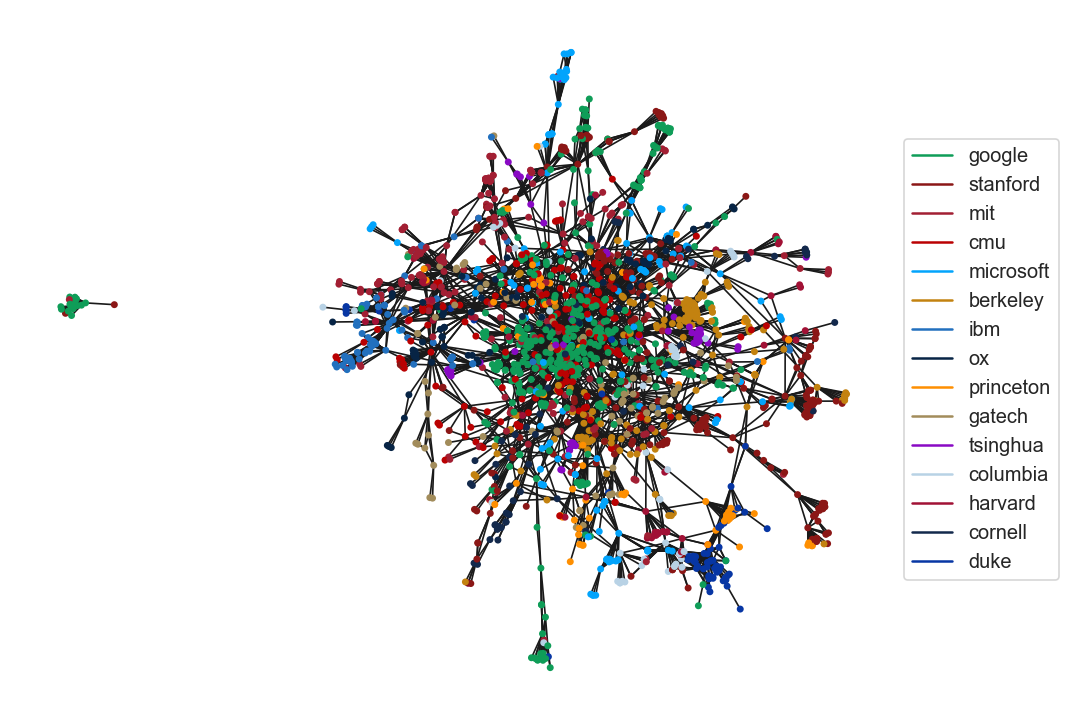

In [92]:
cm=LinearSegmentedColormap.from_list("greens", ['#0f9d58','#8c1515','#a31f34', '#bb0000', '#00a4fe','#c4820f','#1f70c1','#002147','#ff8f00','#a28d5b','#8908c5','#b9d9eb','#A41034','#13294b','#0736A4'])

# val_map = {"microsoft": 0, "google": 1, "princeton": 2}
val_map = {k: v for v, k in enumerate(targets)}
values = [val_map[data['org']] for node, data in M.nodes(data=True)]

fig, ax = plt.subplots(1, 1, figsize=(9,6))
cNorm  = colors.Normalize(vmin=0, vmax=max(values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
for k, v in val_map.items():
    ax.plot([0], [0], color=scalarMap.to_rgba(v), label=k)
    
nx.draw(M, node_size=10, cmap=cm, node_color=values)

plt.axis('off')
fig.set_facecolor('w')
plt.legend(loc="center left", bbox_to_anchor=(1.01, 0.5))
plt.tight_layout()
plt.show()
plt.savefig('top15new.png', dpi=300)

<IPython.core.display.Javascript object>


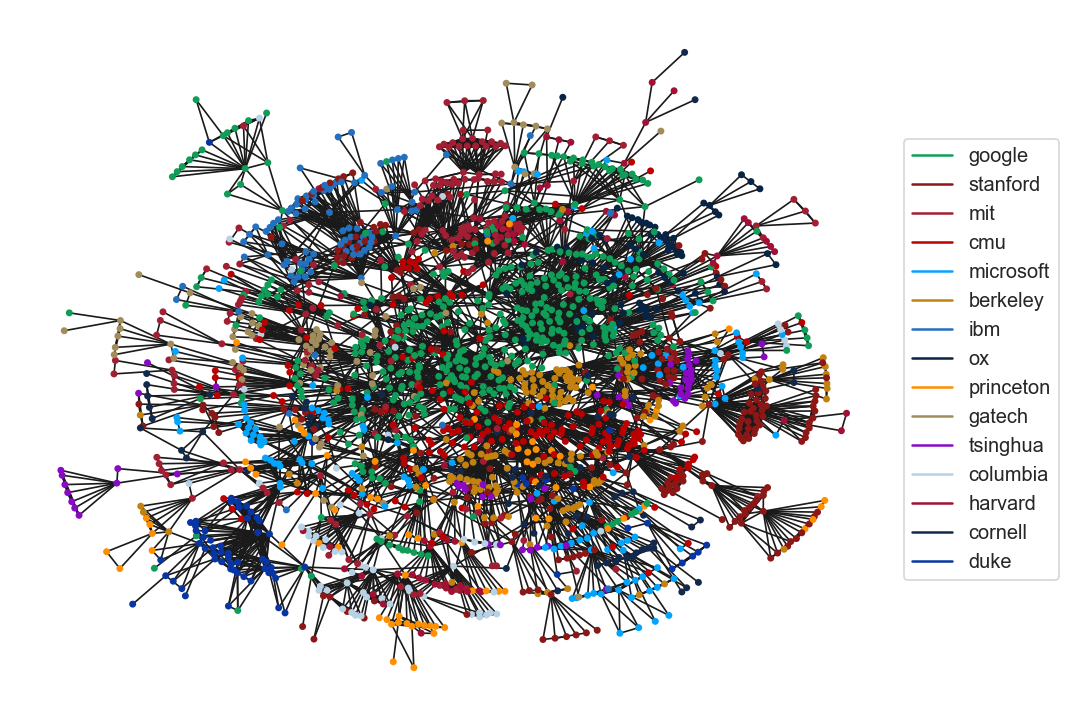

In [93]:
cm=LinearSegmentedColormap.from_list("greens", ['#0f9d58','#8c1515','#a31f34', '#bb0000', '#00a4fe','#c4820f','#1f70c1','#002147','#ff8f00','#a28d5b','#8908c5','#b9d9eb','#A41034','#13294b','#0736A4'])

# val_map = {"microsoft": 0, "google": 1, "princeton": 2}
val_map = {k: v for v, k in enumerate(targets)}
values = [val_map[data['org']] for node, data in M.nodes(data=True)]

fig, ax = plt.subplots(1, 1, figsize=(9,6))
cNorm  = colors.Normalize(vmin=0, vmax=max(values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
for k, v in val_map.items():
    ax.plot([0], [0], color=scalarMap.to_rgba(v), label=k)
    
pos = nx.drawing.layout.kamada_kawai_layout(M)
nx.draw(M, pos=pos, node_size=10, cmap=cm, node_color=values)

plt.axis('off')
fig.set_facecolor('w')
plt.legend(loc="center left", bbox_to_anchor=(1.01, 0.5))
plt.tight_layout()
plt.show()
plt.savefig('top15newall.png', dpi=300)

### Compute network measures (centrality), and construct a dataframe with these measures. Separate academic and industry organizations. Discard organizations with less than 10 people.

In [389]:
EC = nx.eigenvector_centrality(G, max_iter=200)
nx.set_node_attributes(G, EC, "eig_centrality")

EC_ = pd.DataFrame.from_dict(EC, orient="index", columns=["eig_centrality"])
df_ = df_.join(EC_, on="person_id")

In [128]:
BC = nx.betweenness_centrality(G)
nx.set_node_attributes(G, BC, "bet_centrality")

BC_ = pd.DataFrame.from_dict(BC, orient="index", columns=["bet_centrality"])
df_ = df_.join(BC_, on="person_id")

In [388]:
df_.head(1)

,topic,acad_ind,conference,year,index,person_id,paper_id,given_name,family_name,gender,gender_ssa,gender_guesser,org,institution,email,title,tokens,topicprobs,topics,entropy
0,Ethical,Academic,aies,2018,0,rediet-abebe-cornell,32787213278794,Rediet,Abebe,NaN,-1.0,unknown,cornell,cornell universityithacanyusa,x.edu,Computational Perspectives on Social Good and ...,"[computational, perspectives, social, good, ac...","[1.7840914238946043e-10, 1.8815398684715577e-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000004


<IPython.core.display.Javascript object>


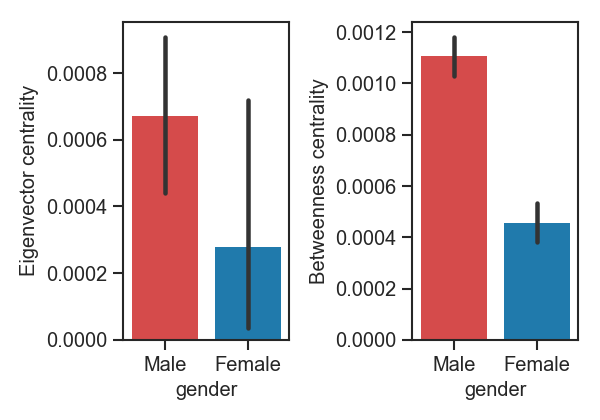

In [188]:
pp = ["#EC3434", "#0981C3"]
fig, ax = plt.subplots(1,2, figsize=(5,3.5))
sns.barplot(x=df_.gender, y=df_.eig_centrality, data=df_, \
            palette=pp, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[0])
sns.barplot(x=df_.gender, y=df_.bet_centrality, data=df_, \
            palette=pp, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[1])
ax[0].set_ylabel('Eigenvector centrality')
ax[1].set_ylabel('Betweenness centrality')
ax[0].set_xticklabels(['Male', 'Female'])
ax[1].set_xticklabels(['Male', 'Female'])

plt.tight_layout()
plt.savefig('gendercentralityY.png', dpi=300)

In [300]:
orgs = {k: v for k,v in Counter(peopledict.values()).items() if (v>10 and k!="gmail")}

acaddict, genderdict, topicdict = {}, {}, {}
for org, orgdf in df_.groupby("org"):
    acaddict[org] = orgdf.acad_ind.mode()[0]
    genderdict[org] = orgdf.gender.mean()
    # This step involves much more than simple aggregation;
    #     Take one-hot topic vectors per paper, and average within organization to produce proportion of 
    #     research output per topic per organization. Then compute the entropy of that as the [Shannon]
    #     diversity index.
    topicdict[org] = stats.entropy(orgdf.topics.mean() / orgdf.topics.mean().sum())
acadind = pd.DataFrame.from_dict(acaddict, orient="index", columns=["acad_ind"])
gender = pd.DataFrame.from_dict(genderdict, orient="index", columns=["gender"])
topic = pd.DataFrame.from_dict(topicdict, orient="index", columns=["div_index"])

av_clustering = {}
av_hierarchy = {}
av_eigcen = {}
av_betcen = {}

for r in orgs.keys():
    try:
        withinorg_nodes = [node for node, data in G.nodes(data=True) if data['org'].lower()==r]
        sub = G.subgraph(withinorg_nodes).copy()
        av_clustering[r] = nx.average_clustering(sub)
        av_hierarchy[r] = nx.global_reaching_centrality(sub)
        av_eigcen[r] = np.nanmean([data["eig_centrality"] for _, data in sub.nodes(data=True)])
        av_betcen[r] = np.nanmean([data["bet_centrality"] for _, data in sub.nodes(data=True)])
    except:
        pass
orgs = pd.DataFrame.from_dict(orgs, orient="index", columns=["org_size"])
av_clustering = pd.DataFrame.from_dict(av_clustering, orient="index", columns=["av_clustering"])
av_hierarchy = pd.DataFrame.from_dict(av_hierarchy, orient="index", columns=["av_hierarchy"])
av_eigcen = pd.DataFrame.from_dict(av_eigcen, orient="index", columns=["av_eigcen"])
av_betcen = pd.DataFrame.from_dict(av_betcen, orient="index", columns=["av_betcen"])

submet = pd.concat((orgs, av_clustering, av_hierarchy, av_eigcen, av_betcen), axis=1)
submet = pd.concat((submet, acadind, gender, topic), axis=1, join="inner")
submet.head()

,org_size,av_clustering,av_hierarchy,av_eigcen,av_betcen,acad_ind,gender,div_index
aalto,25,0.629333,0.156250,3.285540e-08,9.708133e-08,Academic,0.000000,2.159054
adelaide,11,0.675325,0.330000,4.173311e-09,2.188159e-08,Academic,0.000000,1.560710
adobe,32,0.554688,0.220049,3.678449e-08,6.190584e-04,Industry,0.071429,2.306962
alibaba-inc,29,0.572414,0.160714,7.804575e-07,3.643270e-05,Industry,0.200000,2.113328
alleninstitute,13,0.692308,0.222222,5.785459e-06,8.296416e-05,Industry,0.250000,1.297296


<IPython.core.display.Javascript object>


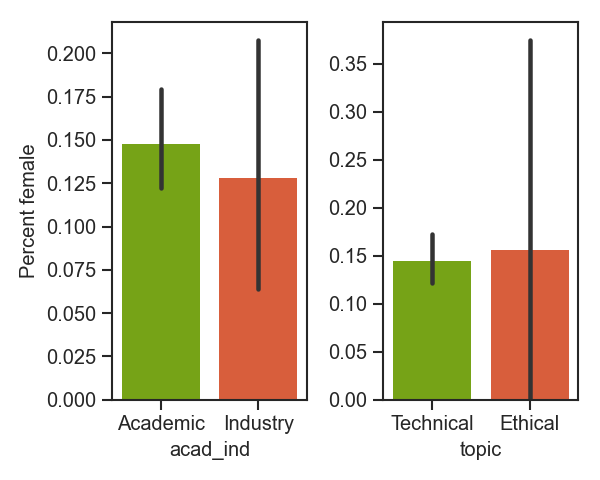

In [111]:
pp = ["#7fba00", "#f25022"]
fig, ax = plt.subplots(1,2, figsize=(5,4))
sns.barplot(x=submet.acad_ind, y=submet.gender, data=submet, \
            palette=pp, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[0])
sns.barplot(x=submet.topic, y=submet.gender, data=submet, \
            palette=pp, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[1])
ax[0].set_ylabel('Percent female')
ax[1].set_ylabel('')

plt.tight_layout()
plt.savefig('gender.png', dpi=300)

<IPython.core.display.Javascript object>


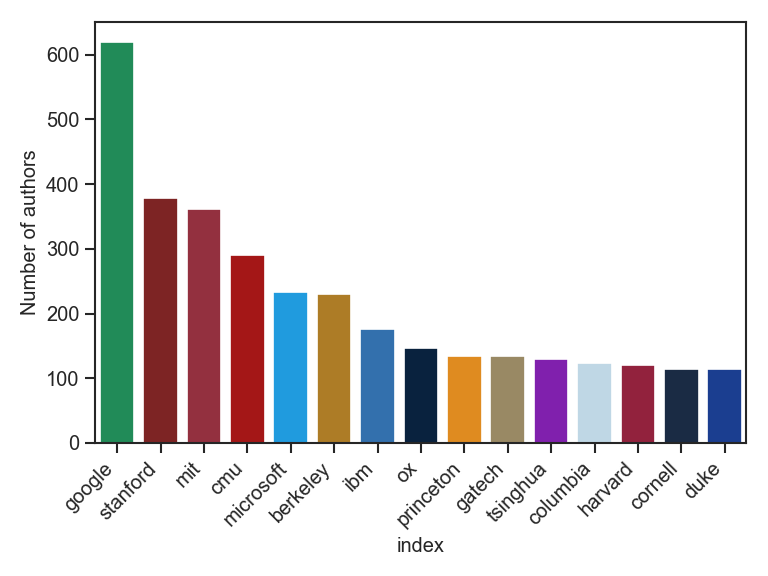

In [88]:
cm=['#0f9d58','#8c1515','#a31f34', '#bb0000', '#00a4fe','#c4820f','#1f70c1','#002147','#ff8f00','#a28d5b','#8908c5','#b9d9eb','#A41034','#13294b','#0736A4']

org_hist = {k: v for k,v in Counter(peopledict.values()).items() if (v>1 and k!="gmail")}
people_hist = pd.DataFrame.from_dict(
    dict(sorted(org_hist.items(), reverse=True, key=lambda x: x[1])),
    orient="index",
    columns=["count"]
)


plt.figure()
sns.barplot(data=people_hist.reset_index().iloc[:15, :], x="index", y="count", palette=cm)
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylabel('Number of authors')
plt.tight_layout()
plt.show()
plt.savefig('top15newdata.png', dpi=300)

In [3]:
# Load file (from same directory as the notebook)
dfs = pd.read_excel(os.path.expanduser("submetnew.xlsx"))
dfs.head()

,Unnamed: 0,rank,org_size,av_clustering,av_hierarchy,av_eigcen,av_betcen,acad_ind,gender,topic,endwt,race
0,colorado,2.4,18,0.333333,0.044983,1.210000e-09,1.664120e-04,Academic,0.173913,2.351807,1.53,NaN
1,oregonstate,2.5,15,0.400000,0.061224,6.390000e-08,0.000000e+00,Academic,0.200000,2.026230,0.60,0.48
2,buffalo,2.7,23,0.613043,0.116736,2.490000e-06,4.620000e-08,Academic,0.333333,2.370044,0.70,NaN
3,indiana,2.9,18,0.659259,0.173010,2.430000e-09,3.920000e-05,Academic,0.111111,2.248386,NaN,NaN
4,rpi,2.9,17,0.176471,0.073568,6.150000e-10,1.650000e-08,Academic,0.100000,2.302759,0.70,NaN


In [5]:
md = smf.ols("av_betcen ~ av_clustering + av_hierarchy + gender + topic + acad_ind + org_size", dfs)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:              av_betcen   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     12.33
Date:                Sat, 10 Jul 2021   Prob (F-statistic):           3.78e-11
Time:                        20:31:28   Log-Likelihood:                 1112.0
No. Observations:                 149   AIC:                            -2210.
Df Residuals:                     142   BIC:                            -2189.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0002 

In [8]:
md = smf.ols("av_eigcen ~ av_clustering + av_hierarchy + gender + topic + acad_ind + org_size", dfs)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:              av_eigcen   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     2.576
Date:                Sat, 10 Jul 2021   Prob (F-statistic):             0.0213
Time:                        20:38:31   Log-Likelihood:                 741.62
No. Observations:                 149   AIC:                            -1469.
Df Residuals:                     142   BIC:                            -1448.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0017 